In this post, I want to finetune our language model and doing text classification using ULMFIT approach for Estonian language.
Note on the Language model:

Here I use the AWD-LSTM language model that I already trained. The procedure of the language model is almost the same as [Pretraining Persian AWD-LSTM Language model](https://saied71.github.io/RohanAiLab/markdown/2021/07/17/Pretraining-Persian-AWD-LSTM-Language-model.html) except for the data.  I used [Oscar](https://huggingface.co/datasets/oscar) dataset, and after cleaning, I've got around 200k articles (~800 MB). for training, it almost took 15 hours on p3 instance of AWS for 10 epochs. Here are the metrics for the last epoch:

|epoch|train_loss|valid_loss|accuracy|perplexity|
|---|---|---|---|---|
|9|4.3451|4.3609|0.29820|78.3298|

For fine-tuning, I couldn't get a standard dataset for benchmarking, so I crawled some news data(around 2700) articles for the sake of demonstration. Maybe in the future, I gathered such a dataset that also can be useful for other tasks.
the classes of data are:

- poliitika(politics)
- kultuur(culture)
- majandus(economy)

Alright, let's get started.

First, we download the model, tokenizer, and the data, which we will use to finetune our language model. after this running this cell, a file named `ULMFIT_ET.zip` will be downloaded, which includes the model, tokenizer, and the data.

In [1]:
%%capture
import gdown
url =  "https://drive.google.com/uc?id=1yWUixE3SpALPtaJjeHdCDIg5bAkhGbz0"
output = 'ULMFIT_ET.zip'
gdown.download(url, output, quiet=False)
!unzip ULMFIT_ET.zip
!pip install -U fastai
!pip install sentencepiece

In [2]:
from fastai import *
from fastai.text import *
from fastai.text.all import *
import pandas as pd
import pickle

import fastai
import torch
print(f"fastai version: {fastai.__version__}")
print(f"GPU which is used : {torch.cuda.get_device_name(0)}")

## parameters for dataloader and tokenizer
lang = "et"
backwards=False
bs=128
vocab_sz = 30000
drop_mult = 0.5
num_workers=18
## setting up the pathes
base = Path(".").absolute()
print(f"our base directory: {base}")
ulmfit_dir = base / "ULMFIT_ET"
print(f"our model and data directory: {ulmfit_dir}")
lm_fns = [ulmfit_dir / f"model_out/{lang}_ULMFIT", ulmfit_dir / f"model_out/{lang}_ULMFIT_vocab"]

fastai version: 2.4.1
GPU which is used : Tesla P100-PCIE-16GB
our base directory: /content
our model and data directory: /content/ULMFIT_ET


In [3]:
df = pd.read_csv(ulmfit_dir / "data_finetune.csv")
print(f"shape of the data: {df.shape}")
df.sample(5)

shape of the data: (2735, 2)


,text,label
1016,"Majandus- ja taristuministri Taavi Aasa hinnangul on veeteetasude langetamise otsus end õigustanud ning seda tuleks teha ka järgnevatel aastatel. Esmaspäeval toimus riigikogu transiidi ja logistika toetusrühma koosolek, kus räägiti aktsiiside ja veeteede tasude mõjust majandusele, riigieelarvele ja ettevõtluse konkurentsivõimele. Arutelul osalesid lisaks Aasale riigikogu liikmed ning rahandusministeeriumi ja ettevõtjate esindajad. “Tänu veeteetasude vähendamisele on Eesti sadamate kaubamaht kumulatiivselt kasvanud 10 protsenti ning tänu kütuseaktsiiside langetusele on paljud ettevõtted taa...",majandus
721,"Sotsiaalministeerium saatis ministeeriumitele ja partneritele kooskõlastamiseks bioloogiliste ohutegurite määruse muutmise eelnõu. Muudatustega uuendatakse töökeskkonna bioloogiliste ohutegurite ohurühmade loetelu, kuhu lisanduvad uued bioloogilised ohutegurid, näiteks koroonaviirus SARS-CoV-2. Muudatused võimaldavad nõuetekohaselt kaitsta töökohtadel töötajate tervist ja tagada ohutust viiruse leviku ajal.„Bioloogilised ohutegurid võivad põhjustada töötajatel erinevaid haigusi – allergiaid, mürgistusi ja nakkuseid. Seega tuleb töökeskkonnas viia töötajate kokkupuude bioloogiliste ohutegur...",poliitika
2344,"„Teater on üks väga lihtne asi. Muud kunsti pole, kui õpid sõnad pähe, ja siis oled näoga rahva poole ja ütled kõva häälega. Ja ajanäitajale pole vaja vaadata. Publiku nägudelt on näha, kui on aeg lõpetada. Ja kui te minuga nõus olete, siis pean ütlema, et teil on hea maitse.” Nii on tänane juubilar, rahvanäitleja Endel Pärn kirjutanud tervitussõnadeks Marvi Taggo raamatule “Endel Pärn. Operetiprofessor” (Faatum 1998).Endel Pärn sündis 21. aprillil 1914 Petrogradis Vassili saarel 4. liinil Aleksander Pärna esimese pojana. Noorema venna nimi oli Ants, ema oli Helene. Endel Pärn on meenutanu...",kultuur
1867,"16. augustil kiitis Vabariigi Valitsus heaks Eesti maaelu arengukava 2014–2020 kolmanda muudatuse, millega muu hulgas lisati arengukavva uus riskijuhtimise toetusmeede. Samuti suurendatakse mahepõllumajanduse toetuse eelarvet, põllumajandusliku tootmise potentsiaali taastamise toetuse eelarvet ning suunatakse lisaraha arengukava rahastamisvahendisse. „Riskijuhtimise meede on uus toetusskeem, mis on ette nähtud erinevate põllumajandustootmist mõjutavate riskidega tegelemiseks. On oluline, et põllumehed tegeleksid riskijuhtimisega, mis aitaks leevendada ilmakahjusid ja tagasilööke turgudel,“...",majandus
481,"Stenbocki maja, 15. detsember 2020 – Peaminister Jüri Ratase sõnul kujutab koroonaviiruse levik Eesti inimeste tervisele ning ühiskonna ja majanduse toimimisele jätkuvalt ohtu ning viiruse leviku pidurdamine sõltub igast inimesest, kuid kui kevadel andis meile jõudu lähenev suvi, siis nüüd saame loota saabuvatele vaktsiinidele.Ratas ütles riigikogu ees tehtud poliitilises avalduses, et pea seitse kuud pärast kevadise eriolukorra lõppu oleme suuresti õppinud koroonaviirusega elama. “Kooseluoskust peame me veel mõnda aega arendama ning seda läheb tarvis, kuni saame vaktsiinide, ravimite ning...",poliitika


Using pretrained SentencePiece for tokenization. Then create a data loader for feeding the language model learner.

In [4]:
tok = SentencePieceTokenizer(lang="et", max_vocab_sz=vocab_sz, sp_model=ulmfit_dir / "spm/spm.model")

In [5]:
dblock_lm = DataBlock(
    blocks=(TextBlock.from_df('text', is_lm=True, tok=tok,backwards=False)),
    get_x=ColReader('text'))


dls_lm = dblock_lm.dataloaders(df, bs=bs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
dls_lm.show_batch(max_n=4)

,text,text_
0,"▁xxbos ▁äsja ▁avaldatud ▁xxup ▁oecd ▁haridus statistika ▁kogumik ▁xxmaj ▁edu c ation ▁ at ▁a ▁xxmaj ▁ gla nce ▁2019 ▁toob ▁esile , ▁et ▁xxmaj ▁eestis ▁on ▁võrreldes ▁teiste ▁riikidega ▁rohkem ▁kõrg hari tuid ▁ja ▁kõrgharidus t ▁asub ▁oma ndama ▁üha ▁enam ▁üle ▁25- aastaseid ▁inimesi , ▁samas ▁veniva d ▁paljude ▁tudengite ▁ õpingud ▁pika le ▁või ▁katke vad . haridus - ▁ja ▁teadusminister ▁xxmaj ▁mailis ▁xxmaj ▁reps i ▁sõnul ▁osutab ▁üks","▁äsja ▁avaldatud ▁xxup ▁oecd ▁haridus statistika ▁kogumik ▁xxmaj ▁edu c ation ▁ at ▁a ▁xxmaj ▁ gla nce ▁2019 ▁toob ▁esile , ▁et ▁xxmaj ▁eestis ▁on ▁võrreldes ▁teiste ▁riikidega ▁rohkem ▁kõrg hari tuid ▁ja ▁kõrgharidus t ▁asub ▁oma ndama ▁üha ▁enam ▁üle ▁25- aastaseid ▁inimesi , ▁samas ▁veniva d ▁paljude ▁tudengite ▁ õpingud ▁pika le ▁või ▁katke vad . haridus - ▁ja ▁teadusminister ▁xxmaj ▁mailis ▁xxmaj ▁reps i ▁sõnul ▁osutab ▁üks ▁olulisemaid"
1,▁juhiks ▁xxmaj ▁ e ster ▁xxmaj ▁ tu ik soo ▁ning ▁aseesimees teks ▁põllumajandus ettevõtja ▁xxmaj ▁kristjan ▁xxmaj ▁roos ve ▁ja ▁xxmaj ▁riigikogu ▁maaelu komisjoni ▁liikme ▁xxmaj ▁kaido ▁ höövel soni . e ster ▁xxmaj ▁ tu ik sool ▁on ▁pikaajaline ▁kogemus ▁põllumajanduse ▁valdkonnas . ▁xxmaj ▁aastatel ▁2004 -20 07 ▁oli ▁xxmaj ▁ e ster ▁xxmaj ▁ tu ik soo ▁kahes ▁valitsuse s ▁põllumajandus minister ▁ning ▁ta ▁on ▁kuulunud ▁xxmaj ▁riigikogu ▁xxup,▁xxmaj ▁ e ster ▁xxmaj ▁ tu ik soo ▁ning ▁aseesimees teks ▁põllumajandus ettevõtja ▁xxmaj ▁kristjan ▁xxmaj ▁roos ve ▁ja ▁xxmaj ▁riigikogu ▁maaelu komisjoni ▁liikme ▁xxmaj ▁kaido ▁ höövel soni . e ster ▁xxmaj ▁ tu ik sool ▁on ▁pikaajaline ▁kogemus ▁põllumajanduse ▁valdkonnas . ▁xxmaj ▁aastatel ▁2004 -20 07 ▁oli ▁xxmaj ▁ e ster ▁xxmaj ▁ tu ik soo ▁kahes ▁valitsuse s ▁põllumajandus minister ▁ning ▁ta ▁on ▁kuulunud ▁xxmaj ▁riigikogu ▁xxup ▁
2,", ▁miks ▁paljud ▁leibkonna d ▁ei ▁sattunud ▁statistilis te ▁vaeste ▁hulka . ma rek ▁xxmaj ▁jürgenson : ▁xxmaj ▁noored ▁vajavad ▁tuge kuri tegevuse ▁enne tamine ▁ja ▁ ohje lda mine ▁on ▁ühiskonnale ▁suurimaks ▁väljakutse ks ▁kõikjal ▁maailmas . ▁xxmaj ▁erandiks ▁pole ▁ka ▁xxmaj ▁eesti . ▁xxmaj ▁taas ise seis vuse ▁aastate ▁jooksul ▁on ▁kuritegevuse ▁ xxunk ▁ja ▁raskus kese ▁märgatavalt ▁muutunud ▁ning ▁üheksa kümne ndate ▁ma ffi a riigi st ▁saanud ▁maailma",▁miks ▁paljud ▁leibkonna d ▁ei ▁sattunud ▁statistilis te ▁vaeste ▁hulka . ma rek ▁xxmaj ▁jürgenson : ▁xxmaj ▁noored ▁vajavad ▁tuge kuri tegevuse ▁enne tamine ▁ja ▁ ohje lda mine ▁on ▁ühiskonnale ▁suurimaks ▁väljakutse ks ▁kõikjal ▁maailmas . ▁xxmaj ▁erandiks ▁pole ▁ka ▁xxmaj ▁eesti . ▁xxmaj ▁taas ise seis vuse ▁aastate ▁jooksul ▁on ▁kuritegevuse ▁ xxunk ▁ja ▁raskus kese ▁märgatavalt ▁muutunud ▁ning ▁üheksa kümne ndate ▁ma ffi a riigi st ▁saanud ▁maailma ▁mõistes
3,"▁nõus taks ▁praeguses ▁kriisi s ▁valitsus t ▁majanduse ▁elavda mise , ▁inimeste ▁toimetuleku ▁parandamise ▁ning ▁ettevõtete ▁ konkurentsivõime ▁kasvatamise ▁küsimustes . „ eesti ▁ja ▁terve ▁maailma ▁majandus ▁on ▁kor oon ap and eemia st ▁tingituna ▁kandnud ▁suuri ▁kahju sid ▁ning ▁seetõttu ▁nõuab ▁majanduse ▁toetamine , ▁inimeste ▁toimetuleku ▁parandamine ▁ja ▁ettevõtete ▁ konkurentsivõime ▁soodusta mine ▁valitsuse lt ▁suurt ▁tähelepanu . ▁xxmaj ▁praegu ▁koos tatava ▁laia põhja lise ▁majanduse ▁elavda mise ▁kava ▁loomiseks ▁peame","taks ▁praeguses ▁kriisi s ▁valitsus t ▁majanduse ▁elavda mise , ▁inimeste ▁toimetuleku ▁parandamise ▁ning ▁ettevõtete ▁ konkurentsivõime ▁kasvatamise ▁küsimustes . „ eesti ▁ja ▁terve ▁maailma ▁majandus ▁on ▁kor oon ap and eemia st ▁tingituna ▁kandnud ▁suuri ▁kahju sid ▁ning ▁seetõttu ▁nõuab ▁majanduse ▁toetamine , ▁inimeste ▁toimetuleku ▁parandamine ▁ja ▁ettevõtete ▁ konkurentsivõime ▁soodusta mine ▁valitsuse lt ▁suurt ▁tähelepanu . ▁xxmaj ▁praegu ▁koos tatava ▁laia põhja lise ▁majanduse ▁elavda mise ▁kava ▁loomiseks ▁peame ▁kasutama"


In [7]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=drop_mult, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_fp16()

Using learning rate finder of fastai. Here we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of the learning rate, so we plot with a log scale. Then, we choose a value that is approximately in the middle of the sharpest downward slope.

For more information on the finding the good learning rate you can refer to this post: [how do you find a good learning rate](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

SuggestedLRs(valley=0.001737800776027143)

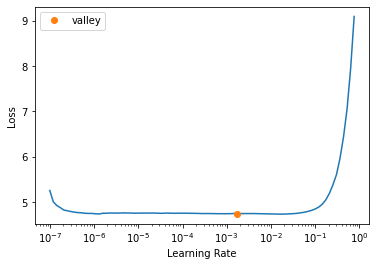

In [ ]:
learn.lr_find()

Next, we finetune the model. By default, a pretrained Learner is in a frozen state, meaning that only the head of the model will train while the body stays frozen.

In [8]:
lr = 2e-3
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.556601,4.277527,0.302157,72.062035,01:25


We can them fine-tune the model after unfreezing

In [9]:
learn.unfreeze()
learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.398276,4.382681,0.291182,80.052361,01:33
1,4.348745,4.372172,0.290859,79.215492,01:33
2,4.134252,4.311713,0.297216,74.568130,01:34
3,3.871403,4.266633,0.305090,71.281227,01:33
4,3.658735,4.233648,0.309295,68.968391,01:34
5,3.459976,4.217117,0.312481,67.837646,01:34
6,3.357300,4.217448,0.312503,67.860069,01:34


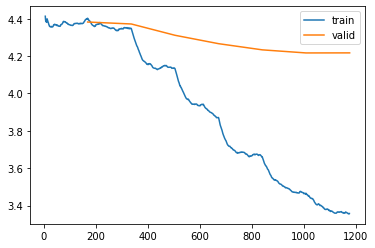

In [10]:
learn.recorder.plot_loss()

According to this plot, we have some overfitting. Obviously, we need more data to finetune our language model. another thing to mention is the valid loss and train loss which have notable differences, and here is an interesting experience that I borrowed from Jeremy Howards in this [thread](https://forums.fast.ai/t/determining-when-you-are-overfitting-underfitting-or-just-right/7732/4) , and I quote:

`
Funnily enough, some over-fitting is nearly always a good thing. All that matters in the end is: is the validation loss as low as you can get it (and/or the val accuracy as high)? This often occurs when the training loss is quite a bit lower.
`

so it's a good idea to train and see when the valid loss starts to grow; that will be our threshold for training. Though this is not the best idea but when we can't get more data, we can make some compromises as we did here.
Another option is data augmentation; that may be in the future; I will jump in that and make some experience and share it with you guys.

Once it's done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the encoder. We can save it with `save_encoder`

In [11]:
learn.save_encoder(ulmfit_dir / 'finetuned')

Here we gather our data for text classification almost exactly like before:

In [12]:
dblocks_clas = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=dls_lm.vocab, backwards=backwards), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'),
                    )
dls_clas = lr = dblocks_clas.dataloaders(df, bs=bs, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
dls_clas.show_batch(max_n=4)

,text,category
0,"▁xxbos ▁xxmaj ▁andres ▁kol liste de ne miseks ▁on ▁tarvis ▁kahte ▁lihtsat ▁asja : ▁inimesi ▁ja ▁energiat . ▁xxmaj ▁see ▁kehtib ▁üksikisiku , ▁perekonna , ▁kogukonna , ▁linna ▁kohta . ▁xxmaj ▁ka ▁riik , ▁maailma ▁riigid , ▁kogu ▁inimkond ▁edene b ▁siis , ▁kui ▁on ▁inimesi ▁ja ▁on ▁energiat . ▁xxmaj ▁inimesi ▁peab ▁olema ▁parasjagu ▁ja ▁neil ▁peab ▁minema ▁hästi . ▁xxmaj ▁energia ▁peab ▁olema ▁kättesaadav ▁kogu ▁aeg , ▁võimalikult ▁väheste ▁ tõrge tega . ▁xxmaj ▁energia ▁eest ▁maksta v ▁hind ▁peab ▁olema ▁mõistlik . ▁xxmaj ▁inimeste ▁kõht ▁peab ▁olema ▁täis . elu ▁xxmaj ▁maal ▁ei ▁saa ▁eksisteeri da ▁energia ta , ▁võime ta ▁energiat ▁kasutada , ▁seda ▁muu ndada . ▁xxmaj ▁energiat ▁kasutab ▁oma ▁elu tegevuse ks ▁viirus ▁( või ▁peaksime ▁tema ▁puhul ▁ütlema , ▁lihtsalt ▁tegevuseks ) , ▁kõige ▁väiksem ▁ bakter , ▁iga ▁taim , ▁iga ▁loom . ▁xxmaj ▁energia ta ▁ei ▁hüppa ▁ konna poeg ki",majandus
1,"▁xxbos ▁xxmaj ▁kallid ▁erakonna kaaslased ! ▁xxmaj ▁austa tud ▁külalised ! ▁xxmaj ▁auväärse d ▁ajakirjanikud ! ▁xxmaj ▁lugupeetud ▁siin viibija d ! sel ▁neljapäeval ▁tähista sime ▁pidulikult ▁oma ▁armsa ▁xxmaj ▁eesti ▁xxmaj ▁vabariigi ▁iseseisvuse ▁taastamise ▁29. ▁aastapäeva . ▁xxmaj ▁homme ▁saame ▁samas ▁märkida ▁ära ▁väga ▁olulise ▁sündmuse ▁meie ▁taas ▁vabaks ▁saamise ▁rajal , ▁kui ▁möödub ▁31 ▁aastat ▁xxmaj ▁balti ▁keti st . ▁xxmaj ▁toonase st ▁ meelsuse st , ▁vabadus i ha st ▁ja ▁xxmaj ▁eesti ▁hinge laadi st ▁sündis ▁ka ▁xxmaj ▁rahva rin ne , ▁millest ▁sai ▁omakorda ▁alguse ▁xxmaj ▁eesti ▁xxmaj ▁keskerakonna ▁sünd ▁ja ▁asu tamine . ▁xxmaj ▁täna ▁oleme ▁seda ▁teed ▁meeles ▁kandes ▁kogunenud ▁xxmaj ▁keskerakonna ▁18. ▁kongressi le . rahva rinde ▁üld programmi ▁ja ▁har ta sse ▁sai ▁toona ▁kirja ▁mitmeid ▁olulisi ▁põhimõtteid , ▁mis ▁väljenda sid ▁meie ▁rahva ▁siiras t ▁soovi ▁ise ▁oma ▁asju ▁otsustada ▁ja ▁tulevikku ▁seada . ▁xxmaj ▁paljud ▁neist ▁ideede st ▁on",poliitika
2,"▁xxbos ▁ühed ▁ rikkad ▁ja ▁kasu tud , ▁kes ▁ himu stavad ▁alati ▁rohkem at ; teist el ▁pole ▁aga ▁midagi ▁ja ▁nad ▁elavad ▁puuduse s , ▁ohtlikud , ▁tunde s ▁liig ▁suurt ▁kadedus t ▁ja ▁läkita vad ▁omanike ▁poole ▁ ti ge da id ▁ nool i . ( e uri pi des ▁„ palu jan na d “ ) ▁xxup ▁karl ▁xxup ▁ lust , ▁ vaatleja parem poolse d ▁ei ▁varja , ▁et ▁jääme ▁tulevikus ▁vähemus rahvus eks ▁omal ▁maal . ▁xxmaj ▁ilma ▁pensioni ta , ▁ilma ▁tasuta ▁hariduse ▁ja ▁arstiabi ta . ▁xxmaj ▁siis ▁kaovad ▁ka ▁demokraatia ▁ja ▁vabadus . ▁xxmaj ▁poliitika ▁ilma ▁filosoofia t ▁tundma ta ▁on ▁pime . ▁xxmaj ▁selgust ▁võiks ▁saada ▁vana - kreeka ▁pärandi ▁ja ▁klassiku te ▁tund misest , ▁sest ▁mustrid ▁korduva d . or ja pidamine ▁jättis ▁kree k lastele ▁rohkelt ▁jõud e aega ▁( kr ▁sch ol é ;",kultuur
3,"▁xxbos ▁xxmaj ▁vinni ▁näidis s ov hoos tehniku m need sama d ▁karda ani d ▁viisid ▁ voliniku ▁xxmaj ▁vinni ▁so v hoos i . ▁xxmaj ▁auto spordi võistlustel ▁xxmaj ▁al u vere ▁auto kross i rajal ▁sai ▁ta ▁tuttavaks ▁xxmaj ▁vinni ▁maja ndi ▁pea insener ▁xxmaj ▁aivo ▁xxmaj ▁al es tega . ▁xxmaj ▁sama ▁mure ▁maja ndi s ▁– ▁suur ▁puudus ▁karda ani dest . ▁xxmaj ▁tuli ▁siis ▁ volinik ▁neile ▁külla , ▁autos ▁ka st ▁karda ane ▁ja ▁risti d ▁peale kauba . ▁xxmaj ▁see ▁avaldas ▁muljet ▁ja ▁xxmaj ▁a le ste ▁jooksis ▁boss ile ▁ette ▁kandma . ▁xxmaj ▁kuna ▁xxmaj ▁vinni ▁maja ndi s ▁õhtu pool ikud ▁möödus id ▁ikka ▁külaliste ga ▁korraliku s ▁lõuna laua s , ▁kutsuti ▁uus ▁mees ▁ennast ▁näitama . direktor ▁xxmaj ▁heino ▁xxmaj ▁kallaste ▁pakkus ▁välja ▁idee ▁minna ▁xxmaj ▁saaremaa ▁kolhoosi ▁ja ▁võtta ▁töö raamatu sse ▁üle viimine ▁nende ▁maja ndi sse",kultuur


The main difference is that we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won't make any sense. We pass that vocabulary with `vocab`.

Then we can define our text classifier like before:

Defing metrics: we use [accuracy](https://docs.fast.ai/metrics.html#accuracy) and [F1Score](https://docs.fast.ai/metrics.html#F1Score)

In [14]:
metrics=[accuracy,F1Score(average="macro")]
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=1, pretrained=False, 
                               metrics=metrics).to_fp16()

learn = learn.load_encoder(ulmfit_dir / 'finetuned')
learn.freeze()

SuggestedLRs(valley=0.0030199517495930195)

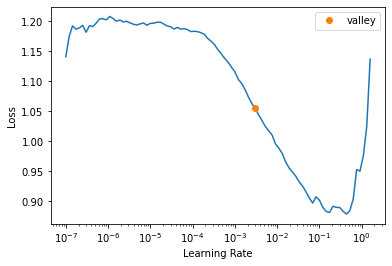

In [15]:
learn.lr_find()

In [16]:
lr = 3e-3
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.823605,0.730970,0.793419,0.793850,00:21


The last step is to train with discriminative learning rates and gradual unfreezing. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.657104,0.534918,0.800731,0.803395,00:24


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.591867,0.450366,0.833638,0.837132,00:32


In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.554562,0.423918,0.839122,0.842716,00:39
1,0.549532,0.412864,0.839122,0.842382,00:38


We still get good results, given that our dataset size for fine-tuning was small.maybe others contribute to this project to make it even better.

You can check out ULMFIT in other languages in this repo: [fastai_ulmfit](https://github.com/floleuerer/fastai_ulmfit), which is an excellent work of Florian.

Here are other useful links :

- [Transfer learning in text](https://docs.fast.ai/tutorial.text.html#The-ULMFiT-approach)
- [Transformers with fastai](https://docs.fast.ai/tutorial.transformers.html)
- [fasthugs](https://github.com/morganmcg1/fasthugs)